In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Dataset

In [2]:
# названия колонок
cols = [
    "fLength",
    "fWidth",
    "fSize",
    "fConc",
    "fConc1",
    "fAsym",
    "fM3Long",
    "fM3Trans",
    "fAlpha",
    "fDist",
    "class",
]

df = pd.read_csv("../data/magic04.data", names=cols)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [4]:
df.describe()

fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000  
mean      -4.331745     10.545545      0.249726     27.645707    193.818026  
std       59.206062     51.000118     20.827439     26.103621     74.731787  
min     -457.916100   -331.780000   -205.894700      0.000000      1.282600  
25%      -20.586550    -12.842775    -10.849375      5.547925    142.492250  
50%        4.013050     15.314100      0.666200     17.679500    191.851450  
75%       24.063700     35.837800     10.946425     45.883550    240.563825  
max      575.240700    238.321000    179.851000     90.000000    495.561000

In [5]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [6]:
# меняем g на 1, h на 0
df["class"] = (df["class"] == "g").astype(int)

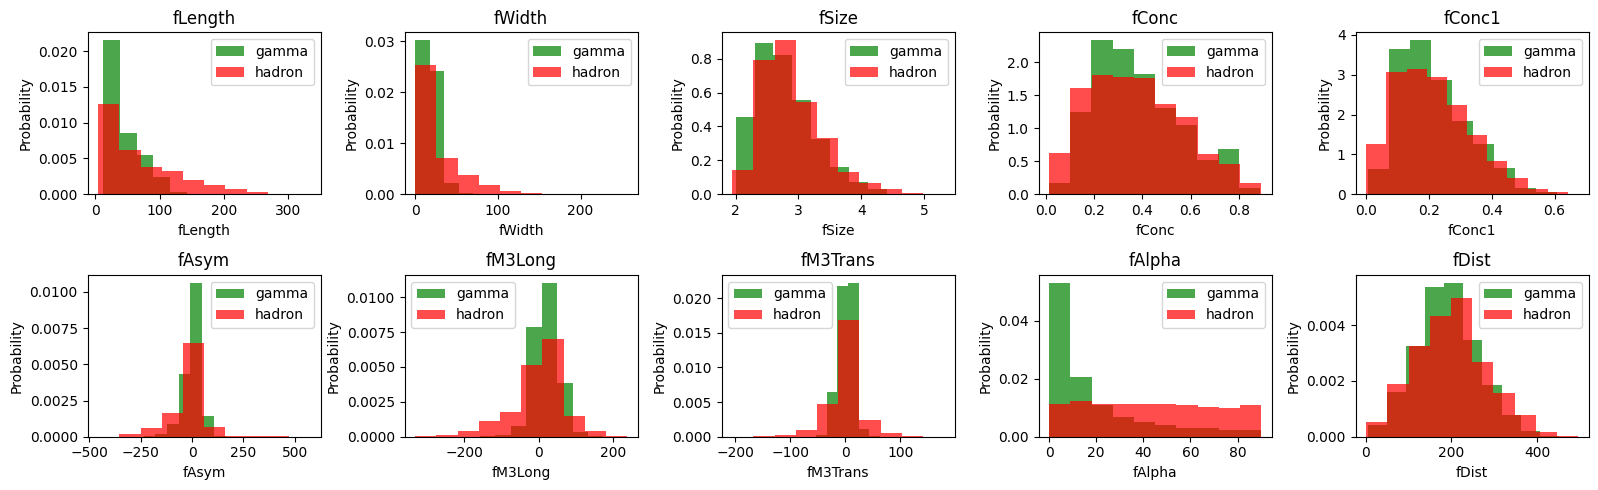

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5))
axes = axes.flatten()

for i, column in enumerate(cols[:-1]):
    ax = axes[i]
    ax.hist(
        df[df["class"] == 1][column],
        color="green",
        label="gamma",
        alpha=0.7,
        density=True,
    )
    ax.hist(
        df[df["class"] == 0][column],
        color="red",
        label="hadron",
        alpha=0.7,
        density=True,
    )
    ax.set(title=column, xlabel=column, ylabel="Probability")
    ax.legend()

plt.tight_layout()
plt.show()

##### Замечания по поводу признаков 

- fAlpha - по мере увеличения признака, вероятность gamma падает, вероятность hadron постоянна.
- fAsym, fM3Long, fLength - распределение вероятности gamma более сконцентрировано, в то время для hadron спад вероятности происходит более плавно
- у остальных признаков различия в распределении вероятности выражены меньше.

### Scaling and Oversampling

In [8]:
from sklearn.model_selection import train_test_split

# Сначала разделяем на тренировочную выборку (train) и временную выборку (temp), которая будет разделена на валидационную и тестовую
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Затем делим временную выборку (temp) на валидационную (valid) и тестовую (test)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

In [9]:
print(f"Количество примеров gamma: {(train['class'] == 1).sum()}")
print(f"Количество примеров hadron: {(train['class'] == 0).sum()}")

Количество примеров gamma: 8627
Количество примеров hadron: 4687


In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler


def scale_and_oversample(df, oversample=False):
    X = df[df.columns[:-1]].values  # Все колонки кроме последней
    y = df[df.columns[-1]].values  # Последняя колонка - это целевая переменная (class)

    # Масштабируем признаки
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        # Применяем овер-сэмплинг
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = pd.DataFrame(X, columns=df.columns[:-1])
    data["class"] = y

    return data, X, y

In [11]:
train, X_train, y_train = scale_and_oversample(train, oversample=True)
valid, X_valid, y_valid = scale_and_oversample(valid)
test, X_test, y_test = scale_and_oversample(test)

##### После овер-сэмплинга

In [12]:
print(f"Количество примеров gamma: {(train['class'] == 1).sum()}")
print(f"Количество примеров hadron: {(train['class'] == 0).sum()}")

Количество примеров gamma: 8627
Количество примеров hadron: 8627


### kNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
y_pred = knn.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1007
           1       0.86      0.86      0.86      1846

    accuracy                           0.82      2853
   macro avg       0.80      0.80      0.80      2853
weighted avg       0.82      0.82      0.82      2853



### Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

In [18]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [19]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.38      0.50      1007
           1       0.73      0.92      0.82      1846

    accuracy                           0.73      2853
   macro avg       0.73      0.65      0.66      2853
weighted avg       0.73      0.73      0.70      2853

